## STAT448 Assignment 3

## Question 2
Datasets CIFAR10 - 10 images classified into things:
0	airplane  
1	automobile  
2	bird  
3	cat  
4	deer  
5	dog  
6	frog  
7	horse  
8	ship  
9	truck  

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf
import optuna

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

SEED = 42
np.random.seed(SEED)

# Utility functions

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# Data import

In [ ]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("Training data shape: ", x_train.shape)
print("Test data shape", x_test.shape)
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)
Training response shape:,  (50000, 1)
Testing response shape:  (10000, 1)


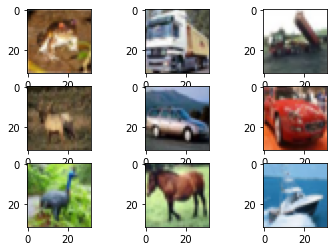

In [ ]:
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i])
plt.show()

In [ ]:
# Flatten the images
image_size = (x_train.shape[1], x_train.shape[2]) #32 x 32 pixels
channels = x_train.shape[3] # RGB = 3 channels
image_vector_size = image_size[0] * image_size[1] * channels
x_train = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)

(50000, 3072)


In [ ]:
# Convert y to "one-hot" vectors using the to_categorical function
print("First 5 training labels: ", y_train[:5])
# [6, 9, 9, 4, 1] = [frog, truck, truck, deer, automobile]
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)


## Model structure
Network with two hidden layers, 128 and 32 neurons.

Input layer = 3072 neurons (32x32 pixels x 3 channels, RGB)

Output layer = 10 neurons (10 digit classes)

In [ ]:
def build_basic_model(n_units):
  model = Sequential()
  model.add(Dense(units=n_units, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=n_units/4, activation='relu'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model(128)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 397,802
Trainable params: 397,802
Non-trainable params: 0
_________________________________________________________________


## Baseline comparison
Neurons in hidden layer = 128 + 32

Optimizer = SGD

Learning rate (default) = 0.01

Batch size = 128

Epochs = 10

In [ ]:
model.compile(optimizer="sgd",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=True,
                    validation_split=.1)
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/10
352/352 [==============================] - 4s 4ms/step - loss: 2.0689 - accuracy: 0.2605 - val_loss: 1.9822 - val_accuracy: 0.2742
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8686 - accuracy: 0.3376 - val_loss: 1.8347 - val_accuracy: 0.3498
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7913 - accuracy: 0.3699 - val_loss: 1.7979 - val_accuracy: 0.3672
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7418 - accuracy: 0.3896 - val_loss: 1.7564 - val_accuracy: 0.3772
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7040 - accuracy: 0.4026 - val_loss: 1.7352 - val_accuracy: 0.3848
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6738 - accuracy: 0.4142 - val_loss: 1.6886 - val_accuracy: 0.4102
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6482 - accuracy: 0.4236 - val_loss: 1.6710 - val_accuracy: 0.4064
Epoch 

Test loss: 1.61
Test accuracy: 0.425


<Figure size 576x432 with 0 Axes>

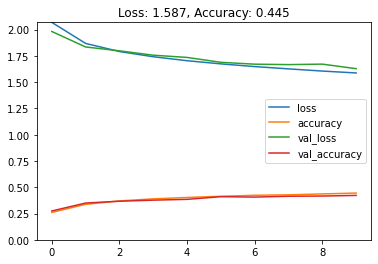

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# not a very good model and very slow to learn!

## Tuning learning rate using random search

In [ ]:
# learning rate
def objective(trial):
    model = build_basic_model(128)
    lr = trial.suggest_float('lr', 1e-4, 1e+2, log=True) #sample value of learning rate between 0.0001 to 100

    model.compile(tf.keras.optimizers.SGD(lr=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

Performance evaluated on 10 different (random) learning rates.

In [ ]:
# metric = accuracy therefore maximise
# set seed to get consistent results
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=10) #use objective function defined above and sample 10 different learning rates

[I 2022-10-19 23:18:51,779] A new study created in memory with name: no-name-41979543-0ed8-41cf-bd85-6dac93aad82b


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0384 - accuracy: 0.2610 - val_loss: 1.9301 - val_accuracy: 0.3018
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8574 - accuracy: 0.3405 - val_loss: 1.8631 - val_accuracy: 0.3398
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7870 - accuracy: 0.3672 - val_loss: 1.8229 - val_accuracy: 0.3430
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7331 - accuracy: 0.3868 - val_loss: 1.7133 - val_accuracy: 0.3900
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6947 - accuracy: 0.4031 - val_loss: 1.6984 - val_accuracy: 0.3888
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6607 - accuracy: 0.4122 - val_loss: 1.6860 - val_accuracy: 0.4022
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 1.6324 - accuracy: 0.4229 - val_loss: 1.6576 - val_accuracy: 0.4156
Epoch 

[I 2022-10-19 23:19:05,558] Trial 0 finished with value: 0.4449999928474426 and parameters: {'lr': 0.017670169402947963}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 14651705344.0000 - accuracy: 0.1003 - val_loss: 18.6270 - val_accuracy: 0.1038
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 14.8575 - accuracy: 0.1020 - val_loss: 15.6362 - val_accuracy: 0.1064
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 15.1201 - accuracy: 0.0995 - val_loss: 16.1297 - val_accuracy: 0.1038
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 15.6484 - accuracy: 0.1002 - val_loss: 19.0502 - val_accuracy: 0.1038
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 14.7522 - accuracy: 0.1009 - val_loss: 13.5571 - val_accuracy: 0.0958
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 15.1420 - accuracy: 0.0996 - val_loss: 14.0853 - val_accuracy: 0.1024
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 15.3281 - accuracy: 0.1005 - val_loss: 19.8974 - val_

[I 2022-10-19 23:19:19,476] Trial 1 finished with value: 0.09759999811649323 and parameters: {'lr': 50.61576888752309}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 356546.5312 - accuracy: 0.0991 - val_loss: 2.3077 - val_accuracy: 0.0950
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3082 - accuracy: 0.0977 - val_loss: 2.3049 - val_accuracy: 0.1058
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3076 - accuracy: 0.1000 - val_loss: 2.3083 - val_accuracy: 0.1058
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3079 - accuracy: 0.0994 - val_loss: 2.3099 - val_accuracy: 0.0976
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3071 - accuracy: 0.1015 - val_loss: 2.3132 - val_accuracy: 0.1058
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3089 - accuracy: 0.0971 - val_loss: 2.3072 - val_accuracy: 0.1038
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3079 - accuracy: 0.0990 - val_loss: 2.3102 - val_accuracy: 0.0970
E

[I 2022-10-19 23:19:32,895] Trial 2 finished with value: 0.10239999741315842 and parameters: {'lr': 2.465832945854912}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.5949 - accuracy: 0.0982 - val_loss: 2.3025 - val_accuracy: 0.0958
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3034 - accuracy: 0.0987 - val_loss: 2.3037 - val_accuracy: 0.0970
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3034 - accuracy: 0.0972 - val_loss: 2.3030 - val_accuracy: 0.0950
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3034 - accuracy: 0.0973 - val_loss: 2.3038 - val_accuracy: 0.0976
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3034 - accuracy: 0.1012 - val_loss: 2.3028 - val_accuracy: 0.0968
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3035 - accuracy: 0.0991 - val_loss: 2.3023 - val_accuracy: 0.1064
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3033 - accuracy: 0.0996 - val_loss: 2.3037 - val_accuracy: 0.0976
Epoch 

[I 2022-10-19 23:19:46,549] Trial 3 finished with value: 0.09860000014305115 and parameters: {'lr': 0.39079671568228835}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 2.2232 - accuracy: 0.1878 - val_loss: 2.1591 - val_accuracy: 0.2236
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 2.1244 - accuracy: 0.2367 - val_loss: 2.0931 - val_accuracy: 0.2410
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 2.0665 - accuracy: 0.2598 - val_loss: 2.0468 - val_accuracy: 0.2620
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 2.0233 - accuracy: 0.2770 - val_loss: 2.0109 - val_accuracy: 0.2770
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.9894 - accuracy: 0.2920 - val_loss: 1.9844 - val_accuracy: 0.2858
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.9628 - accuracy: 0.3048 - val_loss: 1.9618 - val_accuracy: 0.2932
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.9418 - accuracy: 0.3139 - val_loss: 1.9451 - val_accuracy: 0.3048
Epoch 

[I 2022-10-19 23:20:08,000] Trial 4 finished with value: 0.32659998536109924 and parameters: {'lr': 0.0008632008168602544}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.2835 - accuracy: 0.1319 - val_loss: 2.2500 - val_accuracy: 0.1566
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 2.2154 - accuracy: 0.1845 - val_loss: 2.1922 - val_accuracy: 0.2010
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 2.1610 - accuracy: 0.2220 - val_loss: 2.1401 - val_accuracy: 0.2440
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 2.1119 - accuracy: 0.2529 - val_loss: 2.0954 - val_accuracy: 0.2680
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 2.0687 - accuracy: 0.2738 - val_loss: 2.0558 - val_accuracy: 0.2780
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 2.0306 - accuracy: 0.2886 - val_loss: 2.0224 - val_accuracy: 0.2912
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.9984 - accuracy: 0.3040 - val_loss: 1.9941 - val_accuracy: 0.3038
Epoch 

[I 2022-10-19 23:20:29,292] Trial 5 finished with value: 0.31859999895095825 and parameters: {'lr': 0.0008629132190071859}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.3580 - accuracy: 0.0975 - val_loss: 2.3084 - val_accuracy: 0.1112
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 2.2958 - accuracy: 0.1184 - val_loss: 2.2819 - val_accuracy: 0.1368
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 2.2768 - accuracy: 0.1427 - val_loss: 2.2674 - val_accuracy: 0.1568
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 2.2645 - accuracy: 0.1582 - val_loss: 2.2569 - val_accuracy: 0.1692
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 2.2546 - accuracy: 0.1686 - val_loss: 2.2476 - val_accuracy: 0.1750
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 2.2457 - accuracy: 0.1774 - val_loss: 2.2389 - val_accuracy: 0.1828
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 2.2371 - accuracy: 0.1876 - val_loss: 2.2303 - val_accuracy: 0.1970
Epoch 

[I 2022-10-19 23:20:50,557] Trial 6 finished with value: 0.21739999949932098 and parameters: {'lr': 0.00022310108018679258}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 8499298.0000 - accuracy: 0.1004 - val_loss: 2.4983 - val_accuracy: 0.0986
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 2.4531 - accuracy: 0.0972 - val_loss: 2.4350 - val_accuracy: 0.1024
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 2.4459 - accuracy: 0.1004 - val_loss: 2.5791 - val_accuracy: 0.1064
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 2.4412 - accuracy: 0.0999 - val_loss: 2.5297 - val_accuracy: 0.0970
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 2.4356 - accuracy: 0.1014 - val_loss: 2.6340 - val_accuracy: 0.1024
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 2.4355 - accuracy: 0.1035 - val_loss: 2.4841 - val_accuracy: 0.0986
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 2.4494 - accuracy: 0.0984 - val_loss: 2.5152 - val_accuracy: 0.1058


[I 2022-10-19 23:21:04,148] Trial 7 finished with value: 0.10239999741315842 and parameters: {'lr': 15.741890047456648}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.8185 - accuracy: 0.1005 - val_loss: 2.2934 - val_accuracy: 0.0984
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3045 - accuracy: 0.0997 - val_loss: 2.3026 - val_accuracy: 0.0986
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3037 - accuracy: 0.0981 - val_loss: 2.3038 - val_accuracy: 0.0950
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3034 - accuracy: 0.0995 - val_loss: 2.3029 - val_accuracy: 0.0986
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3035 - accuracy: 0.0989 - val_loss: 2.3037 - val_accuracy: 0.0976
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3039 - accuracy: 0.1002 - val_loss: 2.3053 - val_accuracy: 0.0976
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3033 - accuracy: 0.0976 - val_loss: 2.3037 - val_accuracy: 0.1064
Epoch 

[I 2022-10-19 23:21:17,778] Trial 8 finished with value: 0.10379999876022339 and parameters: {'lr': 0.4042872735027334}. Best is trial 0 with value: 0.4449999928474426.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 616.8519 - accuracy: 0.1021 - val_loss: 2.3049 - val_accuracy: 0.0950
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3060 - accuracy: 0.0995 - val_loss: 2.3053 - val_accuracy: 0.1058
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3065 - accuracy: 0.0984 - val_loss: 2.3045 - val_accuracy: 0.0958
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3064 - accuracy: 0.0971 - val_loss: 2.3060 - val_accuracy: 0.0976
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 2.3062 - accuracy: 0.1000 - val_loss: 2.3039 - val_accuracy: 0.1058
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3060 - accuracy: 0.1000 - val_loss: 2.3071 - val_accuracy: 0.1064
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3060 - accuracy: 0.1003 - val_loss: 2.3053 - val_accuracy: 0.1064
Epoc

[I 2022-10-19 23:21:31,193] Trial 9 finished with value: 0.10580000281333923 and parameters: {'lr': 1.7718847354806828}. Best is trial 0 with value: 0.4449999928474426.


In [ ]:
plot_optimization_history(study)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.4449999928474426
  Params: 
    lr: 0.017670169402947963


## Model result with optimised learning rate
Optimal learning rate near default = 0.018

Test accuracy gone from 0.419 to 0.446

In [ ]:
model = build_basic_model(128)
lr = study.best_params['lr']

model.compile(tf.keras.optimizers.SGD(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0099 - accuracy: 0.2683 - val_loss: 1.8769 - val_accuracy: 0.3130
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8311 - accuracy: 0.3425 - val_loss: 1.7748 - val_accuracy: 0.3696
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7599 - accuracy: 0.3723 - val_loss: 1.7509 - val_accuracy: 0.3762
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7115 - accuracy: 0.3944 - val_loss: 1.7242 - val_accuracy: 0.3836
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6702 - accuracy: 0.4068 - val_loss: 2.0119 - val_accuracy: 0.2896
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6427 - accuracy: 0.4196 - val_loss: 1.7361 - val_accuracy: 0.3892
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6139 - accuracy: 0.4269 - val_loss: 1.6552 - val_accuracy: 0.4134
Epoch 

## Tuning batch size

In [ ]:
# batch size, lower batch size = slower training
def objective(trial):
    model = build_basic_model(128)
    batch_size = trial.suggest_int('batch_size', 32, 50000)

    model.compile(optimizer="sgd",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

In [ ]:
search_space = {"batch_size": [32, 64, 128, 256, 512, 1084, 50000]}
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.GridSampler(search_space)
)
study.optimize(objective, n_trials=7)

[I 2022-10-19 23:26:50,691] A new study created in memory with name: no-name-2bb9a19d-87e2-49f1-a637-6fe86b8d3914


Epoch 1/10
704/704 [==============================] - 5s 4ms/step - loss: 2.0021 - accuracy: 0.2710 - val_loss: 2.1074 - val_accuracy: 0.2316
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 1.8090 - accuracy: 0.3566 - val_loss: 1.9376 - val_accuracy: 0.2806
Epoch 3/10
704/704 [==============================] - 2s 3ms/step - loss: 1.7362 - accuracy: 0.3846 - val_loss: 1.9002 - val_accuracy: 0.3160
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 1.6848 - accuracy: 0.4038 - val_loss: 1.8401 - val_accuracy: 0.3424
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 1.6469 - accuracy: 0.4170 - val_loss: 1.8113 - val_accuracy: 0.3398
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 1.6139 - accuracy: 0.4279 - val_loss: 2.0468 - val_accuracy: 0.3260
Epoch 7/10
704/704 [==============================] - 2s 3ms/step - loss: 1.5840 - accuracy: 0.4406 - val_loss: 1.7004 - val_accuracy: 0.3822
Epoch 

[I 2022-10-19 23:27:34,251] Trial 0 finished with value: 0.40639999508857727 and parameters: {'batch_size': 64}. Best is trial 0 with value: 0.40639999508857727.


Epoch 1/10
42/42 [==============================] - 1s 14ms/step - loss: 2.2260 - accuracy: 0.1730 - val_loss: 2.1535 - val_accuracy: 0.2020
Epoch 2/10
42/42 [==============================] - 0s 10ms/step - loss: 2.1143 - accuracy: 0.2232 - val_loss: 2.0831 - val_accuracy: 0.2332
Epoch 3/10
42/42 [==============================] - 0s 10ms/step - loss: 2.0535 - accuracy: 0.2519 - val_loss: 2.0347 - val_accuracy: 0.2534
Epoch 4/10
42/42 [==============================] - 0s 9ms/step - loss: 2.0091 - accuracy: 0.2743 - val_loss: 2.0024 - val_accuracy: 0.2758
Epoch 5/10
42/42 [==============================] - 0s 10ms/step - loss: 1.9758 - accuracy: 0.2884 - val_loss: 1.9716 - val_accuracy: 0.2932
Epoch 6/10
42/42 [==============================] - 0s 9ms/step - loss: 1.9506 - accuracy: 0.3049 - val_loss: 1.9534 - val_accuracy: 0.2962
Epoch 7/10
42/42 [==============================] - 0s 10ms/step - loss: 1.9265 - accuracy: 0.3194 - val_loss: 1.9266 - val_accuracy: 0.3238
Epoch 8/10
42/4

[I 2022-10-19 23:27:39,666] Trial 1 finished with value: 0.3246000111103058 and parameters: {'batch_size': 1084}. Best is trial 0 with value: 0.40639999508857727.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0737 - accuracy: 0.2543 - val_loss: 1.9588 - val_accuracy: 0.2994
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8769 - accuracy: 0.3341 - val_loss: 1.8880 - val_accuracy: 0.3226
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8098 - accuracy: 0.3594 - val_loss: 1.8254 - val_accuracy: 0.3380
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7651 - accuracy: 0.3744 - val_loss: 1.7826 - val_accuracy: 0.3734
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7271 - accuracy: 0.3882 - val_loss: 1.7363 - val_accuracy: 0.3790
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6939 - accuracy: 0.4018 - val_loss: 1.7220 - val_accuracy: 0.3840
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6692 - accuracy: 0.4124 - val_loss: 1.6904 - val_accuracy: 0.4038
Epoch 

[I 2022-10-19 23:27:53,408] Trial 2 finished with value: 0.41280001401901245 and parameters: {'batch_size': 128}. Best is trial 2 with value: 0.41280001401901245.


Epoch 1/10
176/176 [==============================] - 1s 5ms/step - loss: 2.1219 - accuracy: 0.2407 - val_loss: 2.0099 - val_accuracy: 0.2922
Epoch 2/10
176/176 [==============================] - 1s 4ms/step - loss: 1.9430 - accuracy: 0.3095 - val_loss: 1.9051 - val_accuracy: 0.3186
Epoch 3/10
176/176 [==============================] - 1s 5ms/step - loss: 1.8716 - accuracy: 0.3375 - val_loss: 1.8548 - val_accuracy: 0.3458
Epoch 4/10
176/176 [==============================] - 1s 4ms/step - loss: 1.8274 - accuracy: 0.3570 - val_loss: 1.8330 - val_accuracy: 0.3554
Epoch 5/10
176/176 [==============================] - 1s 4ms/step - loss: 1.7963 - accuracy: 0.3666 - val_loss: 1.7993 - val_accuracy: 0.3732
Epoch 6/10
176/176 [==============================] - 1s 4ms/step - loss: 1.7695 - accuracy: 0.3768 - val_loss: 1.7832 - val_accuracy: 0.3684
Epoch 7/10
176/176 [==============================] - 1s 5ms/step - loss: 1.7473 - accuracy: 0.3865 - val_loss: 1.7656 - val_accuracy: 0.3880
Epoch 

[I 2022-10-19 23:28:04,625] Trial 3 finished with value: 0.4004000127315521 and parameters: {'batch_size': 256}. Best is trial 2 with value: 0.41280001401901245.


Epoch 1/10
88/88 [==============================] - 1s 7ms/step - loss: 2.2065 - accuracy: 0.2036 - val_loss: 2.1436 - val_accuracy: 0.2542
Epoch 2/10
88/88 [==============================] - 0s 5ms/step - loss: 2.0735 - accuracy: 0.2724 - val_loss: 2.0213 - val_accuracy: 0.2958
Epoch 3/10
88/88 [==============================] - 0s 5ms/step - loss: 1.9804 - accuracy: 0.3072 - val_loss: 1.9592 - val_accuracy: 0.3108
Epoch 4/10
88/88 [==============================] - 0s 5ms/step - loss: 1.9194 - accuracy: 0.3253 - val_loss: 1.9017 - val_accuracy: 0.3322
Epoch 5/10
88/88 [==============================] - 0s 6ms/step - loss: 1.8771 - accuracy: 0.3394 - val_loss: 1.8895 - val_accuracy: 0.3280
Epoch 6/10
88/88 [==============================] - 0s 5ms/step - loss: 1.8485 - accuracy: 0.3472 - val_loss: 1.8507 - val_accuracy: 0.3404
Epoch 7/10
88/88 [==============================] - 0s 6ms/step - loss: 1.8195 - accuracy: 0.3580 - val_loss: 1.8581 - val_accuracy: 0.3364
Epoch 8/10
88/88 [==

[I 2022-10-19 23:28:10,715] Trial 4 finished with value: 0.36719998717308044 and parameters: {'batch_size': 512}. Best is trial 2 with value: 0.41280001401901245.


Epoch 1/10
1407/1407 [==============================] - 5s 3ms/step - loss: 1.9258 - accuracy: 0.3051 - val_loss: 1.8832 - val_accuracy: 0.3058
Epoch 2/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.7470 - accuracy: 0.3789 - val_loss: 1.8354 - val_accuracy: 0.3348
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6702 - accuracy: 0.4065 - val_loss: 1.7765 - val_accuracy: 0.3694
Epoch 4/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6195 - accuracy: 0.4247 - val_loss: 1.6529 - val_accuracy: 0.4096
Epoch 5/10
1407/1407 [==============================] - 5s 3ms/step - loss: 1.5777 - accuracy: 0.4401 - val_loss: 1.6287 - val_accuracy: 0.4208
Epoch 6/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5422 - accuracy: 0.4522 - val_loss: 1.5836 - val_accuracy: 0.4514
Epoch 7/10
1407/1407 [==============================] - 5s 3ms/step - loss: 1.5148 - accuracy: 0.4625 - val_loss: 1.6712 - val_accuracy:

[I 2022-10-19 23:28:55,598] Trial 5 finished with value: 0.46720001101493835 and parameters: {'batch_size': 32}. Best is trial 5 with value: 0.46720001101493835.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.4025 - accuracy: 0.0774 - val_loss: 2.3552 - val_accuracy: 0.0760
Epoch 2/10
1/1 [==============================] - 0s 310ms/step - loss: 2.3600 - accuracy: 0.0784 - val_loss: 2.3412 - val_accuracy: 0.0838
Epoch 3/10
1/1 [==============================] - 0s 303ms/step - loss: 2.3453 - accuracy: 0.0846 - val_loss: 2.3294 - val_accuracy: 0.0934
Epoch 4/10
1/1 [==============================] - 0s 321ms/step - loss: 2.3332 - accuracy: 0.0926 - val_loss: 2.3190 - val_accuracy: 0.1028
Epoch 5/10
1/1 [==============================] - 0s 312ms/step - loss: 2.3226 - accuracy: 0.1012 - val_loss: 2.3097 - val_accuracy: 0.1152
Epoch 6/10
1/1 [==============================] - 0s 312ms/step - loss: 2.3131 - accuracy: 0.1104 - val_loss: 2.3012 - val_accuracy: 0.1272
Epoch 7/10
1/1 [==============================] - 0s 336ms/step - loss: 2.3044 - accuracy: 0.1192 - val_loss: 2.2936 - val_accuracy: 0.1356
Epoch 8/10
1/1 [=======

[I 2022-10-19 23:29:00,888] Trial 6 finished with value: 0.15299999713897705 and parameters: {'batch_size': 50000}. Best is trial 5 with value: 0.46720001101493835.


In [ ]:
plot_optimization_history(study)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 7
Best trial:
  Value: 0.46720001101493835
  Params: 
    batch_size: 32


## Model result with optimised batch size
Optimum batch size = 128

Test accuracy gone from 0.419 to 0.424

Should be same as baseline

In [ ]:
model = build_basic_model(128)
batch_size = study.best_params['batch_size']

model.compile(optimizer="sgd",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/10
1407/1407 [==============================] - 5s 3ms/step - loss: 1.9441 - accuracy: 0.2932 - val_loss: 1.8313 - val_accuracy: 0.3282
Epoch 2/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.7418 - accuracy: 0.3807 - val_loss: 1.8115 - val_accuracy: 0.3518
Epoch 3/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.6604 - accuracy: 0.4089 - val_loss: 1.7289 - val_accuracy: 0.3884
Epoch 4/10
1407/1407 [==============================] - 5s 3ms/step - loss: 1.6125 - accuracy: 0.4261 - val_loss: 1.8604 - val_accuracy: 0.3364
Epoch 5/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5709 - accuracy: 0.4412 - val_loss: 1.6651 - val_accuracy: 0.3996
Epoch 6/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5366 - accuracy: 0.4561 - val_loss: 1.8233 - val_accuracy: 0.3504
Epoch 7/10
1407/1407 [==============================] - 5s 3ms/step - loss: 1.5104 - accuracy: 0.4648 - val_loss: 1.6411 - val_accuracy:

## Tuning epoch

In [ ]:
# tuning epoch, higher epoch = slower training
def objective(trial):
    model = build_basic_model(128)
    epochs = trial.suggest_int('epochs', 5, 50)

    model.compile(optimizer="sgd",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=epochs,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

In [ ]:
search_space = {"epochs": [5, 10, 20, 50]}
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.GridSampler(search_space)
)
study.optimize(objective, n_trials=4)

[I 2022-10-19 23:31:18,518] A new study created in memory with name: no-name-b142f43c-9286-4c42-a026-a866ab4a398b


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 2.0276 - accuracy: 0.2683 - val_loss: 1.9350 - val_accuracy: 0.3156
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8656 - accuracy: 0.3373 - val_loss: 1.8413 - val_accuracy: 0.3262
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8018 - accuracy: 0.3624 - val_loss: 1.7779 - val_accuracy: 0.3690
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7544 - accuracy: 0.3780 - val_loss: 1.8551 - val_accuracy: 0.3454
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7160 - accuracy: 0.3942 - val_loss: 1.7393 - val_accuracy: 0.3844
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6836 - accuracy: 0.4047 - val_loss: 1.7118 - val_accuracy: 0.4032
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6567 - accuracy: 0.4162 - val_loss: 1.6854 - val_accuracy: 0.3946
Epoch 

[I 2022-10-19 23:31:40,003] Trial 0 finished with value: 0.4124000072479248 and parameters: {'epochs': 10}. Best is trial 0 with value: 0.4124000072479248.


Epoch 1/50
352/352 [==============================] - 2s 4ms/step - loss: 2.0516 - accuracy: 0.2591 - val_loss: 1.9632 - val_accuracy: 0.2918
Epoch 2/50
352/352 [==============================] - 1s 4ms/step - loss: 1.8797 - accuracy: 0.3335 - val_loss: 1.9586 - val_accuracy: 0.3040
Epoch 3/50
352/352 [==============================] - 1s 4ms/step - loss: 1.8126 - accuracy: 0.3609 - val_loss: 1.7942 - val_accuracy: 0.3688
Epoch 4/50
352/352 [==============================] - 1s 4ms/step - loss: 1.7616 - accuracy: 0.3801 - val_loss: 1.7696 - val_accuracy: 0.3780
Epoch 5/50
352/352 [==============================] - 1s 4ms/step - loss: 1.7221 - accuracy: 0.3951 - val_loss: 1.7259 - val_accuracy: 0.3906
Epoch 6/50
352/352 [==============================] - 1s 4ms/step - loss: 1.6888 - accuracy: 0.4055 - val_loss: 1.7127 - val_accuracy: 0.3966
Epoch 7/50
352/352 [==============================] - 1s 4ms/step - loss: 1.6634 - accuracy: 0.4158 - val_loss: 1.6670 - val_accuracy: 0.4120
Epoch 

[I 2022-10-19 23:32:44,452] Trial 1 finished with value: 0.49959999322891235 and parameters: {'epochs': 50}. Best is trial 1 with value: 0.49959999322891235.


Epoch 1/20
352/352 [==============================] - 2s 4ms/step - loss: 2.0757 - accuracy: 0.2487 - val_loss: 1.9562 - val_accuracy: 0.2992
Epoch 2/20
352/352 [==============================] - 1s 4ms/step - loss: 1.8950 - accuracy: 0.3248 - val_loss: 1.8678 - val_accuracy: 0.3484
Epoch 3/20
352/352 [==============================] - 1s 4ms/step - loss: 1.8207 - accuracy: 0.3555 - val_loss: 1.8254 - val_accuracy: 0.3488
Epoch 4/20
352/352 [==============================] - 1s 4ms/step - loss: 1.7729 - accuracy: 0.3731 - val_loss: 1.7630 - val_accuracy: 0.3786
Epoch 5/20
352/352 [==============================] - 1s 4ms/step - loss: 1.7381 - accuracy: 0.3874 - val_loss: 1.7410 - val_accuracy: 0.3774
Epoch 6/20
352/352 [==============================] - 1s 4ms/step - loss: 1.7079 - accuracy: 0.3988 - val_loss: 1.7116 - val_accuracy: 0.4032
Epoch 7/20
352/352 [==============================] - 1s 4ms/step - loss: 1.6854 - accuracy: 0.4069 - val_loss: 1.7185 - val_accuracy: 0.3892
Epoch 

[I 2022-10-19 23:33:11,154] Trial 2 finished with value: 0.4546000063419342 and parameters: {'epochs': 20}. Best is trial 1 with value: 0.49959999322891235.


Epoch 1/5
352/352 [==============================] - 2s 4ms/step - loss: 2.0191 - accuracy: 0.2735 - val_loss: 1.9407 - val_accuracy: 0.2942
Epoch 2/5
352/352 [==============================] - 1s 3ms/step - loss: 1.8604 - accuracy: 0.3418 - val_loss: 1.8583 - val_accuracy: 0.3272
Epoch 3/5
352/352 [==============================] - 1s 4ms/step - loss: 1.7978 - accuracy: 0.3670 - val_loss: 1.8228 - val_accuracy: 0.3576
Epoch 4/5
352/352 [==============================] - 1s 4ms/step - loss: 1.7520 - accuracy: 0.3871 - val_loss: 1.7519 - val_accuracy: 0.3868
Epoch 5/5
352/352 [==============================] - 1s 4ms/step - loss: 1.7118 - accuracy: 0.4015 - val_loss: 1.7586 - val_accuracy: 0.3754


[I 2022-10-19 23:33:18,414] Trial 3 finished with value: 0.37540000677108765 and parameters: {'epochs': 5}. Best is trial 1 with value: 0.49959999322891235.


In [ ]:
plot_optimization_history(study)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 4
Best trial:
  Value: 0.49959999322891235
  Params: 
    epochs: 50


## Model result with optimised epoch
Optimum epoch is the highest = 50

Test accuracy gone from 0.419 to 0.476

In [ ]:
model = build_basic_model(128)
epochs = study.best_params['epochs']

model.compile(optimizer="sgd",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=epochs,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/50
352/352 [==============================] - 2s 4ms/step - loss: 2.0652 - accuracy: 0.2540 - val_loss: 1.9521 - val_accuracy: 0.2978
Epoch 2/50
352/352 [==============================] - 1s 4ms/step - loss: 1.8688 - accuracy: 0.3316 - val_loss: 1.8721 - val_accuracy: 0.3192
Epoch 3/50
352/352 [==============================] - 1s 4ms/step - loss: 1.7975 - accuracy: 0.3618 - val_loss: 1.7920 - val_accuracy: 0.3672
Epoch 4/50
352/352 [==============================] - 1s 4ms/step - loss: 1.7539 - accuracy: 0.3828 - val_loss: 1.7945 - val_accuracy: 0.3742
Epoch 5/50
352/352 [==============================] - 1s 3ms/step - loss: 1.7185 - accuracy: 0.3943 - val_loss: 1.8206 - val_accuracy: 0.3646
Epoch 6/50
352/352 [==============================] - 1s 3ms/step - loss: 1.6910 - accuracy: 0.4032 - val_loss: 1.7095 - val_accuracy: 0.3918
Epoch 7/50
352/352 [==============================] - 1s 4ms/step - loss: 1.6654 - accuracy: 0.4146 - val_loss: 1.6856 - val_accuracy: 0.4052
Epoch 

## Tuning momentum

In [ ]:
# momentum
def objective(trial):
    model = build_basic_model(128)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)

    model.compile(tf.keras.optimizers.SGD(momentum=momentum),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=10)

[I 2022-10-19 23:38:42,070] A new study created in memory with name: no-name-e206ed94-8d17-4631-bbb1-9876114c5e47


Epoch 1/10
352/352 [==============================] - 3s 4ms/step - loss: 2.0232 - accuracy: 0.2700 - val_loss: 1.9119 - val_accuracy: 0.3268
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8422 - accuracy: 0.3477 - val_loss: 1.8183 - val_accuracy: 0.3588
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7694 - accuracy: 0.3795 - val_loss: 1.8006 - val_accuracy: 0.3552
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7143 - accuracy: 0.3995 - val_loss: 1.7125 - val_accuracy: 0.4038
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6674 - accuracy: 0.4119 - val_loss: 1.7031 - val_accuracy: 0.3954
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6324 - accuracy: 0.4251 - val_loss: 1.6669 - val_accuracy: 0.4086
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6014 - accuracy: 0.4345 - val_loss: 1.6035 - val_accuracy: 0.4328
Epoch 

[I 2022-10-19 23:38:57,619] Trial 0 finished with value: 0.4426000118255615 and parameters: {'momentum': 0.3745401188473625}. Best is trial 0 with value: 0.4426000118255615.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9368 - accuracy: 0.2953 - val_loss: 1.8279 - val_accuracy: 0.3366
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7578 - accuracy: 0.3662 - val_loss: 1.6950 - val_accuracy: 0.3948
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6810 - accuracy: 0.3982 - val_loss: 1.6663 - val_accuracy: 0.4030
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6297 - accuracy: 0.4156 - val_loss: 1.6294 - val_accuracy: 0.4242
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5920 - accuracy: 0.4304 - val_loss: 1.6532 - val_accuracy: 0.4142
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 1.5660 - accuracy: 0.4373 - val_loss: 1.5889 - val_accuracy: 0.4268
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5365 - accuracy: 0.4453 - val_loss: 1.5725 - val_accuracy: 0.4456
Epoch 

[I 2022-10-19 23:39:13,215] Trial 1 finished with value: 0.4535999894142151 and parameters: {'momentum': 0.9507143064099162}. Best is trial 1 with value: 0.4535999894142151.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9703 - accuracy: 0.2902 - val_loss: 1.8598 - val_accuracy: 0.3280
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7654 - accuracy: 0.3728 - val_loss: 1.7379 - val_accuracy: 0.3804
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6869 - accuracy: 0.4034 - val_loss: 1.6573 - val_accuracy: 0.4118
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6328 - accuracy: 0.4226 - val_loss: 1.7225 - val_accuracy: 0.3974
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5885 - accuracy: 0.4386 - val_loss: 1.6404 - val_accuracy: 0.4212
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5562 - accuracy: 0.4484 - val_loss: 1.5787 - val_accuracy: 0.4482
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5298 - accuracy: 0.4570 - val_loss: 1.5771 - val_accuracy: 0.4436
Epoch 

[I 2022-10-19 23:39:27,219] Trial 2 finished with value: 0.44920000433921814 and parameters: {'momentum': 0.7319939418114051}. Best is trial 1 with value: 0.4535999894142151.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9843 - accuracy: 0.2837 - val_loss: 1.8681 - val_accuracy: 0.3328
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7864 - accuracy: 0.3641 - val_loss: 1.7688 - val_accuracy: 0.3716
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7110 - accuracy: 0.3900 - val_loss: 1.7049 - val_accuracy: 0.4046
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6579 - accuracy: 0.4130 - val_loss: 1.6763 - val_accuracy: 0.4026
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6204 - accuracy: 0.4241 - val_loss: 1.6133 - val_accuracy: 0.4292
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5821 - accuracy: 0.4379 - val_loss: 1.6251 - val_accuracy: 0.4238
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5552 - accuracy: 0.4473 - val_loss: 1.6006 - val_accuracy: 0.4358
Epoch 

[I 2022-10-19 23:39:48,669] Trial 3 finished with value: 0.4505999982357025 and parameters: {'momentum': 0.5986584841970366}. Best is trial 1 with value: 0.4535999894142151.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0075 - accuracy: 0.2726 - val_loss: 1.9038 - val_accuracy: 0.3192
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8523 - accuracy: 0.3452 - val_loss: 1.8317 - val_accuracy: 0.3554
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7870 - accuracy: 0.3720 - val_loss: 1.7972 - val_accuracy: 0.3582
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7361 - accuracy: 0.3904 - val_loss: 1.7245 - val_accuracy: 0.3896
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6980 - accuracy: 0.4028 - val_loss: 1.7263 - val_accuracy: 0.3938
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6632 - accuracy: 0.4135 - val_loss: 1.6672 - val_accuracy: 0.4106
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6379 - accuracy: 0.4229 - val_loss: 1.6788 - val_accuracy: 0.4044
Epoch 

[I 2022-10-19 23:40:02,695] Trial 4 finished with value: 0.4352000057697296 and parameters: {'momentum': 0.15601864044243652}. Best is trial 1 with value: 0.4535999894142151.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0924 - accuracy: 0.2423 - val_loss: 1.9292 - val_accuracy: 0.3106
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8668 - accuracy: 0.3394 - val_loss: 1.9141 - val_accuracy: 0.2852
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7927 - accuracy: 0.3680 - val_loss: 1.8099 - val_accuracy: 0.3606
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7437 - accuracy: 0.3846 - val_loss: 1.8273 - val_accuracy: 0.3564
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7072 - accuracy: 0.3975 - val_loss: 1.7825 - val_accuracy: 0.3640
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6746 - accuracy: 0.4063 - val_loss: 1.6880 - val_accuracy: 0.4096
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6489 - accuracy: 0.4196 - val_loss: 1.7117 - val_accuracy: 0.3862
Epoch 

[I 2022-10-19 23:40:16,897] Trial 5 finished with value: 0.4449999928474426 and parameters: {'momentum': 0.15599452033620265}. Best is trial 1 with value: 0.4535999894142151.


Epoch 1/10
352/352 [==============================] - 3s 5ms/step - loss: 2.0691 - accuracy: 0.2501 - val_loss: 1.9547 - val_accuracy: 0.2870
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8738 - accuracy: 0.3346 - val_loss: 1.8566 - val_accuracy: 0.3272
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8044 - accuracy: 0.3635 - val_loss: 1.8045 - val_accuracy: 0.3686
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7565 - accuracy: 0.3794 - val_loss: 1.7737 - val_accuracy: 0.3594
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7186 - accuracy: 0.3951 - val_loss: 1.7301 - val_accuracy: 0.3992
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 1.6872 - accuracy: 0.4059 - val_loss: 1.6979 - val_accuracy: 0.4028
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6604 - accuracy: 0.4200 - val_loss: 1.6763 - val_accuracy: 0.4114
Epoch 

[I 2022-10-19 23:40:39,062] Trial 6 finished with value: 0.40540000796318054 and parameters: {'momentum': 0.05808361216819946}. Best is trial 1 with value: 0.4535999894142151.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9075 - accuracy: 0.3097 - val_loss: 1.8024 - val_accuracy: 0.3454
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7227 - accuracy: 0.3868 - val_loss: 1.7225 - val_accuracy: 0.3834
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6537 - accuracy: 0.4105 - val_loss: 1.6344 - val_accuracy: 0.4200
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5992 - accuracy: 0.4303 - val_loss: 1.5810 - val_accuracy: 0.4410
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.5584 - accuracy: 0.4455 - val_loss: 1.5839 - val_accuracy: 0.4388
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5244 - accuracy: 0.4572 - val_loss: 1.5776 - val_accuracy: 0.4464
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.4996 - accuracy: 0.4659 - val_loss: 1.5003 - val_accuracy: 0.4714
Epoch 

[I 2022-10-19 23:41:00,368] Trial 7 finished with value: 0.47699999809265137 and parameters: {'momentum': 0.8661761457749352}. Best is trial 7 with value: 0.47699999809265137.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9928 - accuracy: 0.2814 - val_loss: 1.9220 - val_accuracy: 0.2944
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8014 - accuracy: 0.3622 - val_loss: 1.8286 - val_accuracy: 0.3598
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7181 - accuracy: 0.3929 - val_loss: 1.7070 - val_accuracy: 0.3960
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6582 - accuracy: 0.4156 - val_loss: 1.6967 - val_accuracy: 0.3930
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6123 - accuracy: 0.4286 - val_loss: 1.6432 - val_accuracy: 0.4220
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5780 - accuracy: 0.4442 - val_loss: 1.6185 - val_accuracy: 0.4268
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5488 - accuracy: 0.4537 - val_loss: 1.5711 - val_accuracy: 0.4456
Epoch 

[I 2022-10-19 23:41:21,660] Trial 8 finished with value: 0.4408000111579895 and parameters: {'momentum': 0.6011150117432088}. Best is trial 7 with value: 0.47699999809265137.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9558 - accuracy: 0.2971 - val_loss: 1.8162 - val_accuracy: 0.3572
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7525 - accuracy: 0.3751 - val_loss: 1.7249 - val_accuracy: 0.3858
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6743 - accuracy: 0.4049 - val_loss: 1.6979 - val_accuracy: 0.3986
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6246 - accuracy: 0.4228 - val_loss: 1.6268 - val_accuracy: 0.4202
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5769 - accuracy: 0.4425 - val_loss: 1.5820 - val_accuracy: 0.4366
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5394 - accuracy: 0.4550 - val_loss: 1.5759 - val_accuracy: 0.4444
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5152 - accuracy: 0.4639 - val_loss: 1.5140 - val_accuracy: 0.4668
Epoch 

[I 2022-10-19 23:41:42,924] Trial 9 finished with value: 0.4657999873161316 and parameters: {'momentum': 0.7080725777960455}. Best is trial 7 with value: 0.47699999809265137.


In [ ]:
plot_optimization_history(study)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.47699999809265137
  Params: 
    momentum: 0.8661761457749352


## Model result with optimised momentum
Optimum momentum is very high = 0.87

Test accuracy gone from 0.419 to 0.475

In [ ]:
model = build_basic_model(128)
momentum = study.best_params['momentum']

model.compile(tf.keras.optimizers.SGD(momentum=momentum),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9399 - accuracy: 0.2967 - val_loss: 1.8100 - val_accuracy: 0.3430
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7347 - accuracy: 0.3792 - val_loss: 1.7286 - val_accuracy: 0.3824
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6538 - accuracy: 0.4103 - val_loss: 1.6867 - val_accuracy: 0.3952
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6040 - accuracy: 0.4308 - val_loss: 1.5895 - val_accuracy: 0.4364
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5694 - accuracy: 0.4418 - val_loss: 1.5594 - val_accuracy: 0.4478
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 1.5287 - accuracy: 0.4573 - val_loss: 1.5264 - val_accuracy: 0.4590
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5127 - accuracy: 0.4592 - val_loss: 1.5153 - val_accuracy: 0.4594
Epoch 

## Tuning optimiser function

In [ ]:
# optimiser
def objective(trial):
    model = build_basic_model(128)
    optimizer = trial.suggest_categorical("optimizer", ["sgd", "adam", "adamax", "nadam", "rmsprop", "ftrl", "adadelta", "adagrad"])

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

In [ ]:
search_space = {"optimizer": ["sgd", "adam", "adamax", "nadam", "rmsprop", "ftrl", "adadelta", "adagrad"]}
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.GridSampler(search_space)
)
print(study)
study.optimize(objective, n_trials=8)

[I 2022-10-19 23:42:37,258] A new study created in memory with name: no-name-6e7312d8-dd4e-4848-825d-20e6da15b4d2


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.2939 - accuracy: 0.1453 - val_loss: 2.2719 - val_accuracy: 0.1786
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 2.2607 - accuracy: 0.1732 - val_loss: 2.2482 - val_accuracy: 0.1902
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 2.2416 - accuracy: 0.1865 - val_loss: 2.2310 - val_accuracy: 0.1994
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 2.2264 - accuracy: 0.1969 - val_loss: 2.2168 - val_accuracy: 0.2132
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 2.2125 - accuracy: 0.2065 - val_loss: 2.2036 - val_accuracy: 0.2168
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 2.1997 - accuracy: 0.2145 - val_loss: 2.1913 - val_accuracy: 0.2206
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 2.1854 - accuracy: 0.2207 - val_loss: 2.1760 - val_accuracy: 0.2312
Epoch 

[I 2022-10-19 23:42:51,398] Trial 0 finished with value: 0.23579999804496765 and parameters: {'optimizer': 'adadelta'}. Best is trial 0 with value: 0.23579999804496765.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0836 - accuracy: 0.2511 - val_loss: 1.9488 - val_accuracy: 0.2990
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8773 - accuracy: 0.3328 - val_loss: 1.8424 - val_accuracy: 0.3476
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8071 - accuracy: 0.3620 - val_loss: 1.8346 - val_accuracy: 0.3432
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7595 - accuracy: 0.3792 - val_loss: 1.7646 - val_accuracy: 0.3700
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7208 - accuracy: 0.3911 - val_loss: 1.7267 - val_accuracy: 0.3870
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6857 - accuracy: 0.4033 - val_loss: 1.6948 - val_accuracy: 0.3988
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6599 - accuracy: 0.4130 - val_loss: 1.7022 - val_accuracy: 0.4080
Epoch 

[I 2022-10-19 23:43:05,590] Trial 1 finished with value: 0.4251999855041504 and parameters: {'optimizer': 'adamax'}. Best is trial 1 with value: 0.4251999855041504.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9895 - accuracy: 0.2676 - val_loss: 1.8618 - val_accuracy: 0.3298
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7705 - accuracy: 0.3665 - val_loss: 1.7621 - val_accuracy: 0.3724
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6931 - accuracy: 0.3932 - val_loss: 1.6977 - val_accuracy: 0.3896
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6459 - accuracy: 0.4139 - val_loss: 1.6923 - val_accuracy: 0.3932
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6104 - accuracy: 0.4268 - val_loss: 1.6180 - val_accuracy: 0.4314
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5821 - accuracy: 0.4335 - val_loss: 1.6478 - val_accuracy: 0.4042
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5606 - accuracy: 0.4419 - val_loss: 1.5677 - val_accuracy: 0.4462
Epoch 

[I 2022-10-19 23:43:27,109] Trial 2 finished with value: 0.45320001244544983 and parameters: {'optimizer': 'adam'}. Best is trial 2 with value: 0.45320001244544983.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 2.0488 - accuracy: 0.2444 - val_loss: 1.8822 - val_accuracy: 0.3168
Epoch 2/10
352/352 [==============================] - 2s 4ms/step - loss: 1.8137 - accuracy: 0.3484 - val_loss: 1.8575 - val_accuracy: 0.3494
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 1.7321 - accuracy: 0.3819 - val_loss: 1.7126 - val_accuracy: 0.3894
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6760 - accuracy: 0.4022 - val_loss: 1.6662 - val_accuracy: 0.4014
Epoch 5/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6397 - accuracy: 0.4154 - val_loss: 1.6719 - val_accuracy: 0.4132
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6052 - accuracy: 0.4270 - val_loss: 1.6084 - val_accuracy: 0.4238
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5732 - accuracy: 0.4391 - val_loss: 1.6032 - val_accuracy: 0.4346
Epoch 

[I 2022-10-19 23:43:44,393] Trial 3 finished with value: 0.4514000117778778 and parameters: {'optimizer': 'nadam'}. Best is trial 2 with value: 0.45320001244544983.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.1724 - accuracy: 0.2037 - val_loss: 1.9661 - val_accuracy: 0.2720
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.9074 - accuracy: 0.3043 - val_loss: 1.8679 - val_accuracy: 0.3290
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8100 - accuracy: 0.3460 - val_loss: 1.8382 - val_accuracy: 0.3380
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7452 - accuracy: 0.3727 - val_loss: 1.7486 - val_accuracy: 0.3814
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6967 - accuracy: 0.3937 - val_loss: 1.6805 - val_accuracy: 0.3940
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6563 - accuracy: 0.4095 - val_loss: 1.8084 - val_accuracy: 0.3694
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6254 - accuracy: 0.4214 - val_loss: 1.7249 - val_accuracy: 0.3852
Epoch 

[I 2022-10-19 23:43:59,557] Trial 4 finished with value: 0.43860000371932983 and parameters: {'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.45320001244544983.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0161 - accuracy: 0.2749 - val_loss: 1.9690 - val_accuracy: 0.2854
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8527 - accuracy: 0.3447 - val_loss: 1.8398 - val_accuracy: 0.3420
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7914 - accuracy: 0.3667 - val_loss: 1.7831 - val_accuracy: 0.3664
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7472 - accuracy: 0.3847 - val_loss: 1.7680 - val_accuracy: 0.3870
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7138 - accuracy: 0.3949 - val_loss: 1.7177 - val_accuracy: 0.3940
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 1.6837 - accuracy: 0.4081 - val_loss: 1.7362 - val_accuracy: 0.3820
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6563 - accuracy: 0.4165 - val_loss: 1.6659 - val_accuracy: 0.4128
Epoch 

[I 2022-10-19 23:44:20,808] Trial 5 finished with value: 0.42480000853538513 and parameters: {'optimizer': 'sgd'}. Best is trial 2 with value: 0.45320001244544983.


Epoch 1/10
352/352 [==============================] - 2s 6ms/step - loss: 2.3030 - accuracy: 0.0970 - val_loss: 2.3026 - val_accuracy: 0.0958
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0990 - val_loss: 2.3026 - val_accuracy: 0.0958
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.0958
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.0958
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.0950
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0990 - val_loss: 2.3026 - val_accuracy: 0.0950
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 2.3026 - accuracy: 0.0990 - val_loss: 2.3026 - val_accuracy: 0.0950
Epoch 

[I 2022-10-19 23:44:42,828] Trial 6 finished with value: 0.0949999988079071 and parameters: {'optimizer': 'ftrl'}. Best is trial 2 with value: 0.45320001244544983.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.1449 - accuracy: 0.2255 - val_loss: 2.0526 - val_accuracy: 0.2724
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.9957 - accuracy: 0.2867 - val_loss: 1.9640 - val_accuracy: 0.3112
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.9277 - accuracy: 0.3150 - val_loss: 1.9210 - val_accuracy: 0.3180
Epoch 4/10
352/352 [==============================] - 2s 5ms/step - loss: 1.8874 - accuracy: 0.3351 - val_loss: 1.8862 - val_accuracy: 0.3400
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 1.8599 - accuracy: 0.3474 - val_loss: 1.8662 - val_accuracy: 0.3452
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8394 - accuracy: 0.3558 - val_loss: 1.8459 - val_accuracy: 0.3572
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8225 - accuracy: 0.3638 - val_loss: 1.8357 - val_accuracy: 0.3610
Epoch 

[I 2022-10-19 23:44:57,540] Trial 7 finished with value: 0.37439998984336853 and parameters: {'optimizer': 'adagrad'}. Best is trial 2 with value: 0.45320001244544983.


In [ ]:
plot_optimization_history(study)


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 8
Best trial:
  Value: 0.45320001244544983
  Params: 
    optimizer: adam


## Model result with optimised optimizer
Optimum optimizer is nadam

Test accuracy gone from 0.419 to 0.436

In [ ]:
model = build_basic_model(128)
optimizer = study.best_params['optimizer']

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0435 - accuracy: 0.2222 - val_loss: 2.0816 - val_accuracy: 0.2404
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8491 - accuracy: 0.3221 - val_loss: 1.8017 - val_accuracy: 0.3440
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7695 - accuracy: 0.3550 - val_loss: 1.7366 - val_accuracy: 0.3684
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7177 - accuracy: 0.3770 - val_loss: 1.7075 - val_accuracy: 0.3852
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6712 - accuracy: 0.3990 - val_loss: 1.6732 - val_accuracy: 0.3926
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6201 - accuracy: 0.4178 - val_loss: 1.6130 - val_accuracy: 0.4188
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5871 - accuracy: 0.4295 - val_loss: 1.5914 - val_accuracy: 0.4298
Epoch 

## Tuning model architecture

In [ ]:
# model size - optimising model architecture
def objective(trial):
    n_units = trial.suggest_int("n_units", 16, 1024)
    model = build_basic_model(n_units)

    model.compile(optimizer="sgd",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=10)

[I 2022-10-19 23:51:29,576] A new study created in memory with name: no-name-fcdd4ded-423b-4f38-b6c4-4837ffcaadbf


Epoch 1/10
352/352 [==============================] - 3s 4ms/step - loss: 1.9838 - accuracy: 0.2959 - val_loss: 1.8696 - val_accuracy: 0.3388
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8146 - accuracy: 0.3635 - val_loss: 1.7922 - val_accuracy: 0.3720
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 1.7511 - accuracy: 0.3866 - val_loss: 1.7814 - val_accuracy: 0.3672
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7058 - accuracy: 0.4038 - val_loss: 1.7503 - val_accuracy: 0.3798
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6678 - accuracy: 0.4182 - val_loss: 1.6744 - val_accuracy: 0.4080
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6391 - accuracy: 0.4281 - val_loss: 1.6648 - val_accuracy: 0.4188
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6109 - accuracy: 0.4389 - val_loss: 1.6206 - val_accuracy: 0.4374
Epoch 

[I 2022-10-19 23:51:51,215] Trial 0 finished with value: 0.4413999915122986 and parameters: {'n_units': 393}. Best is trial 0 with value: 0.4413999915122986.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9612 - accuracy: 0.2985 - val_loss: 1.9164 - val_accuracy: 0.3196
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7949 - accuracy: 0.3693 - val_loss: 1.7774 - val_accuracy: 0.3638
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7235 - accuracy: 0.3928 - val_loss: 1.8358 - val_accuracy: 0.3376
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6760 - accuracy: 0.4119 - val_loss: 1.6891 - val_accuracy: 0.4122
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6368 - accuracy: 0.4280 - val_loss: 1.6614 - val_accuracy: 0.4156
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6045 - accuracy: 0.4400 - val_loss: 1.6592 - val_accuracy: 0.4114
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5764 - accuracy: 0.4491 - val_loss: 1.6065 - val_accuracy: 0.4424
Epoch 

[I 2022-10-19 23:52:12,746] Trial 1 finished with value: 0.44600000977516174 and parameters: {'n_units': 975}. Best is trial 1 with value: 0.44600000977516174.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9476 - accuracy: 0.3061 - val_loss: 1.8541 - val_accuracy: 0.3472
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7911 - accuracy: 0.3708 - val_loss: 1.8302 - val_accuracy: 0.3380
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7266 - accuracy: 0.3953 - val_loss: 1.7061 - val_accuracy: 0.4006
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6794 - accuracy: 0.4116 - val_loss: 1.6832 - val_accuracy: 0.4076
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6424 - accuracy: 0.4263 - val_loss: 1.7571 - val_accuracy: 0.3712
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6108 - accuracy: 0.4366 - val_loss: 1.6129 - val_accuracy: 0.4386
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5836 - accuracy: 0.4479 - val_loss: 1.5876 - val_accuracy: 0.4500
Epoch 

[I 2022-10-19 23:52:28,091] Trial 2 finished with value: 0.41679999232292175 and parameters: {'n_units': 754}. Best is trial 1 with value: 0.44600000977516174.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9647 - accuracy: 0.2984 - val_loss: 1.8798 - val_accuracy: 0.3306
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8008 - accuracy: 0.3650 - val_loss: 1.7860 - val_accuracy: 0.3708
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7340 - accuracy: 0.3909 - val_loss: 1.7333 - val_accuracy: 0.3926
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6823 - accuracy: 0.4107 - val_loss: 1.6961 - val_accuracy: 0.3986
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6467 - accuracy: 0.4234 - val_loss: 1.6559 - val_accuracy: 0.4142
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6132 - accuracy: 0.4355 - val_loss: 1.6264 - val_accuracy: 0.4272
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5835 - accuracy: 0.4464 - val_loss: 1.6572 - val_accuracy: 0.4062
Epoch 

[I 2022-10-19 23:52:49,530] Trial 3 finished with value: 0.4424000084400177 and parameters: {'n_units': 620}. Best is trial 1 with value: 0.44600000977516174.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0467 - accuracy: 0.2671 - val_loss: 1.9851 - val_accuracy: 0.2838
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8787 - accuracy: 0.3354 - val_loss: 1.8518 - val_accuracy: 0.3428
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8073 - accuracy: 0.3645 - val_loss: 1.8044 - val_accuracy: 0.3734
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7582 - accuracy: 0.3821 - val_loss: 1.7881 - val_accuracy: 0.3662
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7213 - accuracy: 0.3967 - val_loss: 1.7874 - val_accuracy: 0.3658
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6878 - accuracy: 0.4074 - val_loss: 1.7120 - val_accuracy: 0.4010
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6644 - accuracy: 0.4159 - val_loss: 1.7060 - val_accuracy: 0.4008
Epoch 

[I 2022-10-19 23:53:03,476] Trial 4 finished with value: 0.42899999022483826 and parameters: {'n_units': 173}. Best is trial 1 with value: 0.44600000977516174.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0313 - accuracy: 0.2731 - val_loss: 1.9456 - val_accuracy: 0.2930
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8551 - accuracy: 0.3454 - val_loss: 1.8395 - val_accuracy: 0.3556
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7898 - accuracy: 0.3701 - val_loss: 1.8205 - val_accuracy: 0.3540
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7456 - accuracy: 0.3839 - val_loss: 1.7534 - val_accuracy: 0.3824
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7065 - accuracy: 0.3986 - val_loss: 1.7468 - val_accuracy: 0.3712
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6785 - accuracy: 0.4085 - val_loss: 1.6892 - val_accuracy: 0.3966
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 1.6508 - accuracy: 0.4186 - val_loss: 1.6732 - val_accuracy: 0.4126
Epoch 

[I 2022-10-19 23:53:24,942] Trial 5 finished with value: 0.41999998688697815 and parameters: {'n_units': 173}. Best is trial 1 with value: 0.44600000977516174.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 2.0731 - accuracy: 0.2434 - val_loss: 1.9820 - val_accuracy: 0.2756
Epoch 2/10
352/352 [==============================] - 1s 3ms/step - loss: 1.9084 - accuracy: 0.3158 - val_loss: 1.8878 - val_accuracy: 0.3138
Epoch 3/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8455 - accuracy: 0.3447 - val_loss: 1.8607 - val_accuracy: 0.3396
Epoch 4/10
352/352 [==============================] - 1s 3ms/step - loss: 1.8025 - accuracy: 0.3594 - val_loss: 1.8301 - val_accuracy: 0.3548
Epoch 5/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7695 - accuracy: 0.3728 - val_loss: 1.7862 - val_accuracy: 0.3616
Epoch 6/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7440 - accuracy: 0.3830 - val_loss: 1.7407 - val_accuracy: 0.3856
Epoch 7/10
352/352 [==============================] - 1s 3ms/step - loss: 1.7197 - accuracy: 0.3915 - val_loss: 1.7593 - val_accuracy: 0.3824
Epoch 

[I 2022-10-19 23:53:38,505] Trial 6 finished with value: 0.3952000141143799 and parameters: {'n_units': 74}. Best is trial 1 with value: 0.44600000977516174.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9705 - accuracy: 0.2973 - val_loss: 1.8938 - val_accuracy: 0.3274
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8032 - accuracy: 0.3662 - val_loss: 1.8063 - val_accuracy: 0.3684
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7332 - accuracy: 0.3952 - val_loss: 1.7384 - val_accuracy: 0.3830
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6830 - accuracy: 0.4118 - val_loss: 1.7031 - val_accuracy: 0.3902
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6439 - accuracy: 0.4245 - val_loss: 1.6891 - val_accuracy: 0.4066
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6123 - accuracy: 0.4377 - val_loss: 1.6461 - val_accuracy: 0.4234
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5812 - accuracy: 0.4481 - val_loss: 1.6237 - val_accuracy: 0.4274
Epoch 

[I 2022-10-19 23:53:59,797] Trial 7 finished with value: 0.4465999901294708 and parameters: {'n_units': 889}. Best is trial 7 with value: 0.4465999901294708.


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9696 - accuracy: 0.2988 - val_loss: 1.8842 - val_accuracy: 0.3276
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8032 - accuracy: 0.3659 - val_loss: 1.8131 - val_accuracy: 0.3468
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7367 - accuracy: 0.3901 - val_loss: 1.7366 - val_accuracy: 0.3840
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6890 - accuracy: 0.4100 - val_loss: 1.6932 - val_accuracy: 0.3984
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6530 - accuracy: 0.4196 - val_loss: 1.6544 - val_accuracy: 0.4294
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6218 - accuracy: 0.4333 - val_loss: 1.6575 - val_accuracy: 0.4104
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5934 - accuracy: 0.4429 - val_loss: 1.6142 - val_accuracy: 0.4344
Epoch 

[I 2022-10-19 23:54:21,057] Trial 8 finished with value: 0.44920000433921814 and parameters: {'n_units': 622}. Best is trial 8 with value: 0.44920000433921814.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9605 - accuracy: 0.3004 - val_loss: 1.9233 - val_accuracy: 0.3150
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7996 - accuracy: 0.3682 - val_loss: 1.7771 - val_accuracy: 0.3642
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7339 - accuracy: 0.3936 - val_loss: 1.7237 - val_accuracy: 0.4040
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6850 - accuracy: 0.4106 - val_loss: 1.6937 - val_accuracy: 0.4070
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6455 - accuracy: 0.4258 - val_loss: 1.6609 - val_accuracy: 0.4224
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6147 - accuracy: 0.4349 - val_loss: 1.6486 - val_accuracy: 0.4224
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5884 - accuracy: 0.4456 - val_loss: 1.6175 - val_accuracy: 0.4344
Epoch 

[I 2022-10-19 23:54:36,139] Trial 9 finished with value: 0.4339999854564667 and parameters: {'n_units': 730}. Best is trial 8 with value: 0.44920000433921814.


In [ ]:
plot_optimization_history(study)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.44920000433921814
  Params: 
    n_units: 622


## Model result with optimised neurons
Optimum number of neurons is 975

Test accuracy gone from 0.419 to 0.451

In [ ]:
model = build_basic_model(study.best_params['n_units'])

model.compile(optimizer="sgd",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 1.9566 - accuracy: 0.3002 - val_loss: 1.8440 - val_accuracy: 0.3466
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 1.8003 - accuracy: 0.3677 - val_loss: 1.7828 - val_accuracy: 0.3774
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7338 - accuracy: 0.3921 - val_loss: 1.7378 - val_accuracy: 0.3984
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6838 - accuracy: 0.4100 - val_loss: 1.7111 - val_accuracy: 0.3952
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6474 - accuracy: 0.4254 - val_loss: 1.6529 - val_accuracy: 0.4116
Epoch 6/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6172 - accuracy: 0.4350 - val_loss: 1.6450 - val_accuracy: 0.4182
Epoch 7/10
352/352 [==============================] - 1s 4ms/step - loss: 1.5861 - accuracy: 0.4480 - val_loss: 1.5998 - val_accuracy: 0.4422
Epoch 

## Model result with tuned parameters
neurons = 975

optimizer = sgd

learning rate = 0.0177

momentum = 0.866

batch size = 128

epochs = 50

In [ ]:
model = build_basic_model(975)

model.compile(tf.keras.optimizers.SGD(lr=0.0177, momentum=0.866),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/50
352/352 [==============================] - 2s 5ms/step - loss: 1.8413 - accuracy: 0.3356 - val_loss: 1.7005 - val_accuracy: 0.3910
Epoch 2/50
352/352 [==============================] - 2s 4ms/step - loss: 1.6518 - accuracy: 0.4106 - val_loss: 1.6474 - val_accuracy: 0.4076
Epoch 3/50
352/352 [==============================] - 2s 4ms/step - loss: 1.5772 - accuracy: 0.4363 - val_loss: 1.5715 - val_accuracy: 0.4366
Epoch 4/50
352/352 [==============================] - 2s 4ms/step - loss: 1.5153 - accuracy: 0.4593 - val_loss: 1.5196 - val_accuracy: 0.4680
Epoch 5/50
352/352 [==============================] - 2s 4ms/step - loss: 1.4681 - accuracy: 0.4784 - val_loss: 1.4845 - val_accuracy: 0.4746
Epoch 6/50
352/352 [==============================] - 2s 4ms/step - loss: 1.4256 - accuracy: 0.4908 - val_loss: 1.4408 - val_accuracy: 0.4954
Epoch 7/50
352/352 [==============================] - 2s 4ms/step - loss: 1.3863 - accuracy: 0.5048 - val_loss: 1.4623 - val_accuracy: 0.4724
Epoch 

Test loss: 1.99
Test accuracy: 0.528


<Figure size 576x432 with 0 Axes>

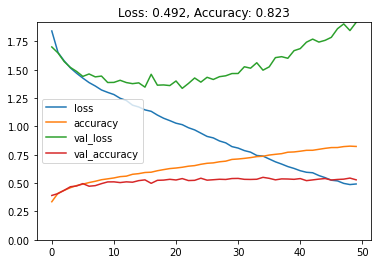

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [ ]:
model = build_basic_model(975)

model.compile(optimizer="nadam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Epoch 1/50
352/352 [==============================] - 3s 7ms/step - loss: 1.9787 - accuracy: 0.2977 - val_loss: 1.8132 - val_accuracy: 0.3510
Epoch 2/50
352/352 [==============================] - 2s 6ms/step - loss: 1.7136 - accuracy: 0.3882 - val_loss: 1.8165 - val_accuracy: 0.3520
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 1.6144 - accuracy: 0.4251 - val_loss: 1.7018 - val_accuracy: 0.3834
Epoch 4/50
352/352 [==============================] - 2s 6ms/step - loss: 1.5486 - accuracy: 0.4496 - val_loss: 1.6237 - val_accuracy: 0.4260
Epoch 5/50
352/352 [==============================] - 2s 6ms/step - loss: 1.4945 - accuracy: 0.4672 - val_loss: 1.5515 - val_accuracy: 0.4554
Epoch 6/50
352/352 [==============================] - 2s 6ms/step - loss: 1.4520 - accuracy: 0.4844 - val_loss: 1.5203 - val_accuracy: 0.4680
Epoch 7/50
352/352 [==============================] - 2s 6ms/step - loss: 1.4129 - accuracy: 0.4956 - val_loss: 1.5514 - val_accuracy: 0.4562
Epoch 

Test loss: 2.2
Test accuracy: 0.499


<Figure size 576x432 with 0 Axes>

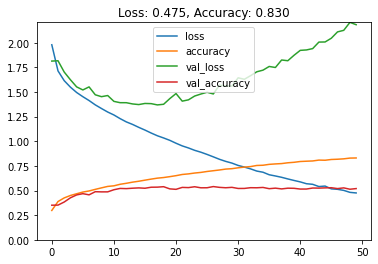

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Tuning parameters at the same time

Batch size set at 128 and Epoch set at 10 to keep training time reasonable, optimizer set as Nadam

Tuning parameters = learning rate, neurons


In [ ]:
# Optimising learning rate & neuron number together
def objective(trial):
    n_units = trial.suggest_int("n_units", 16, 1024)
    model = build_basic_model(n_units)

    lr = trial.suggest_float('lr', 1e-4, 1e+2, log=True) #sample value of learning rate between 0.0001 to 100

    model.compile(tf.keras.optimizers.Nadam(lr=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=True,
                        validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=10)

[I 2022-10-19 00:41:09,010] A new study created in memory with name: no-name-db4a6664-2d16-48b1-8447-8540de8184cb


Epoch 1/10
352/352 [==============================] - 3s 5ms/step - loss: 1772444288.0000 - accuracy: 0.1032 - val_loss: 42.7953 - val_accuracy: 0.1058
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 44.3075 - accuracy: 0.1008 - val_loss: 41.2381 - val_accuracy: 0.1058
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 43.2186 - accuracy: 0.0991 - val_loss: 58.6273 - val_accuracy: 0.0950
Epoch 4/10
352/352 [==============================] - 2s 5ms/step - loss: 41.9640 - accuracy: 0.0996 - val_loss: 48.6722 - val_accuracy: 0.0986
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 41.4478 - accuracy: 0.0986 - val_loss: 35.8428 - val_accuracy: 0.0958
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 38.9847 - accuracy: 0.0979 - val_loss: 20.4847 - val_accuracy: 0.0970
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 37.4795 - accuracy: 0.1018 - val_loss: 33.4799 - val_a

[I 2022-10-19 00:41:27,812] Trial 0 finished with value: 0.10379999876022339 and parameters: {'n_units': 393, 'lr': 50.61576888752309}. Best is trial 0 with value: 0.10379999876022339.


Epoch 1/10
352/352 [==============================] - 3s 6ms/step - loss: 3422.4268 - accuracy: 0.1006 - val_loss: 3.3537 - val_accuracy: 0.1064
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3123 - accuracy: 0.1043 - val_loss: 3.3695 - val_accuracy: 0.1036
Epoch 3/10
352/352 [==============================] - 2s 6ms/step - loss: 2.3162 - accuracy: 0.0970 - val_loss: 3.3812 - val_accuracy: 0.0950
Epoch 4/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3158 - accuracy: 0.1009 - val_loss: 3.3629 - val_accuracy: 0.0986
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3177 - accuracy: 0.1012 - val_loss: 3.3592 - val_accuracy: 0.1036
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 2.3174 - accuracy: 0.1000 - val_loss: 3.3780 - val_accuracy: 0.1064
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3174 - accuracy: 0.1012 - val_loss: 3.3720 - val_accuracy: 0.1058
Epo

[I 2022-10-19 00:41:49,974] Trial 1 finished with value: 0.10239999741315842 and parameters: {'n_units': 754, 'lr': 0.39079671568228835}. Best is trial 0 with value: 0.10379999876022339.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9809 - accuracy: 0.2826 - val_loss: 1.8988 - val_accuracy: 0.3180
Epoch 2/10
352/352 [==============================] - 2s 4ms/step - loss: 1.7619 - accuracy: 0.3728 - val_loss: 1.7590 - val_accuracy: 0.3654
Epoch 3/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6773 - accuracy: 0.4034 - val_loss: 1.6504 - val_accuracy: 0.4152
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6159 - accuracy: 0.4252 - val_loss: 1.6413 - val_accuracy: 0.4132
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5729 - accuracy: 0.4394 - val_loss: 1.6320 - val_accuracy: 0.4248
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5361 - accuracy: 0.4558 - val_loss: 1.5948 - val_accuracy: 0.4366
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5178 - accuracy: 0.4625 - val_loss: 1.5539 - val_accuracy: 0.4492
Epoch 

[I 2022-10-19 00:42:06,938] Trial 2 finished with value: 0.46399998664855957 and parameters: {'n_units': 173, 'lr': 0.0008629132190071859}. Best is trial 2 with value: 0.46399998664855957.


Epoch 1/10
352/352 [==============================] - 3s 6ms/step - loss: 2774893.0000 - accuracy: 0.0972 - val_loss: 9.9373 - val_accuracy: 0.1024
Epoch 2/10
352/352 [==============================] - 2s 4ms/step - loss: 11.4289 - accuracy: 0.0986 - val_loss: 8.9107 - val_accuracy: 0.1024
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 9.9099 - accuracy: 0.0998 - val_loss: 9.8145 - val_accuracy: 0.0950
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 10.0881 - accuracy: 0.0998 - val_loss: 15.8185 - val_accuracy: 0.0958
Epoch 5/10
352/352 [==============================] - 2s 4ms/step - loss: 10.2796 - accuracy: 0.1004 - val_loss: 7.5216 - val_accuracy: 0.1024
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 9.8695 - accuracy: 0.1012 - val_loss: 13.7625 - val_accuracy: 0.0950
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 9.1313 - accuracy: 0.0987 - val_loss: 11.7260 - val_accuracy: 0

[I 2022-10-19 00:42:24,223] Trial 3 finished with value: 0.10239999741315842 and parameters: {'n_units': 74, 'lr': 15.741890047456648}. Best is trial 2 with value: 0.46399998664855957.


Epoch 1/10
352/352 [==============================] - 4s 7ms/step - loss: 205250.0312 - accuracy: 0.0972 - val_loss: 44.7395 - val_accuracy: 0.0950
Epoch 2/10
352/352 [==============================] - 2s 7ms/step - loss: 2.3739 - accuracy: 0.0991 - val_loss: 44.7530 - val_accuracy: 0.0976
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 2.4052 - accuracy: 0.1008 - val_loss: 44.8758 - val_accuracy: 0.0976
Epoch 4/10
352/352 [==============================] - 2s 5ms/step - loss: 2.4168 - accuracy: 0.1000 - val_loss: 44.8016 - val_accuracy: 0.1058
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 2.4164 - accuracy: 0.0995 - val_loss: 44.8106 - val_accuracy: 0.0958
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 2.4072 - accuracy: 0.1000 - val_loss: 44.7162 - val_accuracy: 0.0976
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 2.4089 - accuracy: 0.0993 - val_loss: 44.7767 - val_accuracy: 0

[I 2022-10-19 00:42:45,669] Trial 4 finished with value: 0.0949999988079071 and parameters: {'n_units': 622, 'lr': 1.7718847354806828}. Best is trial 2 with value: 0.46399998664855957.


Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 18466406.0000 - accuracy: 0.1007 - val_loss: 48.3938 - val_accuracy: 0.0986
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 58.1724 - accuracy: 0.1004 - val_loss: 62.9339 - val_accuracy: 0.0970
Epoch 3/10
352/352 [==============================] - 2s 4ms/step - loss: 56.6852 - accuracy: 0.1000 - val_loss: 46.2777 - val_accuracy: 0.0958
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 55.5758 - accuracy: 0.0986 - val_loss: 50.4538 - val_accuracy: 0.1024
Epoch 5/10
352/352 [==============================] - 2s 4ms/step - loss: 54.1953 - accuracy: 0.0999 - val_loss: 57.0624 - val_accuracy: 0.1038
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 51.7907 - accuracy: 0.1008 - val_loss: 21.4961 - val_accuracy: 0.0970
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 50.5697 - accuracy: 0.1004 - val_loss: 43.5399 - val_acc

[I 2022-10-19 00:43:04,864] Trial 5 finished with value: 0.09759999811649323 and parameters: {'n_units': 36, 'lr': 65.98711072054076}. Best is trial 2 with value: 0.46399998664855957.


Epoch 1/10
352/352 [==============================] - 3s 7ms/step - loss: 2.0677 - accuracy: 0.2869 - val_loss: 1.9157 - val_accuracy: 0.2944
Epoch 2/10
352/352 [==============================] - 2s 6ms/step - loss: 1.7423 - accuracy: 0.3802 - val_loss: 1.7663 - val_accuracy: 0.3620
Epoch 3/10
352/352 [==============================] - 2s 6ms/step - loss: 1.6526 - accuracy: 0.4113 - val_loss: 1.6939 - val_accuracy: 0.3962
Epoch 4/10
352/352 [==============================] - 2s 6ms/step - loss: 1.5858 - accuracy: 0.4373 - val_loss: 1.5736 - val_accuracy: 0.4474
Epoch 5/10
352/352 [==============================] - 2s 6ms/step - loss: 1.5272 - accuracy: 0.4563 - val_loss: 1.5778 - val_accuracy: 0.4332
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 1.4901 - accuracy: 0.4690 - val_loss: 1.5157 - val_accuracy: 0.4638
Epoch 7/10
352/352 [==============================] - 2s 6ms/step - loss: 1.4421 - accuracy: 0.4855 - val_loss: 1.6425 - val_accuracy: 0.4270
Epoch 

[I 2022-10-19 00:43:47,597] Trial 6 finished with value: 0.49059998989105225 and parameters: {'n_units': 855, 'lr': 0.0018794668241638478}. Best is trial 6 with value: 0.49059998989105225.


Epoch 1/10
352/352 [==============================] - 3s 5ms/step - loss: 1.9827 - accuracy: 0.2822 - val_loss: 1.8375 - val_accuracy: 0.3228
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 1.7651 - accuracy: 0.3650 - val_loss: 1.7730 - val_accuracy: 0.3622
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6758 - accuracy: 0.3996 - val_loss: 1.7181 - val_accuracy: 0.3926
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6216 - accuracy: 0.4246 - val_loss: 1.6547 - val_accuracy: 0.4078
Epoch 5/10
352/352 [==============================] - 2s 4ms/step - loss: 1.5788 - accuracy: 0.4406 - val_loss: 1.6470 - val_accuracy: 0.4166
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5418 - accuracy: 0.4532 - val_loss: 1.5422 - val_accuracy: 0.4466
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 1.5095 - accuracy: 0.4648 - val_loss: 1.5410 - val_accuracy: 0.4558
Epoch 

[I 2022-10-19 00:44:05,501] Trial 7 finished with value: 0.4650000035762787 and parameters: {'n_units': 199, 'lr': 0.0012601639723276807}. Best is trial 6 with value: 0.49059998989105225.


Epoch 1/10
352/352 [==============================] - 3s 5ms/step - loss: 38.6848 - accuracy: 0.1004 - val_loss: 2.3197 - val_accuracy: 0.1064
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3068 - accuracy: 0.0993 - val_loss: 2.3177 - val_accuracy: 0.1064
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3076 - accuracy: 0.1000 - val_loss: 2.3218 - val_accuracy: 0.1024
Epoch 4/10
352/352 [==============================] - 2s 6ms/step - loss: 2.3079 - accuracy: 0.1004 - val_loss: 2.3207 - val_accuracy: 0.0958
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3085 - accuracy: 0.0949 - val_loss: 2.3176 - val_accuracy: 0.0958
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3087 - accuracy: 0.0992 - val_loss: 2.3224 - val_accuracy: 0.0950
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 2.3086 - accuracy: 0.0989 - val_loss: 2.3180 - val_accuracy: 0.1058
Epoch

[I 2022-10-19 00:44:26,337] Trial 8 finished with value: 0.0957999974489212 and parameters: {'n_units': 322, 'lr': 0.14077923139972406}. Best is trial 6 with value: 0.49059998989105225.


Epoch 1/10
352/352 [==============================] - 4s 8ms/step - loss: 2.4485 - accuracy: 0.2454 - val_loss: 1.9084 - val_accuracy: 0.3236
Epoch 2/10
352/352 [==============================] - 2s 6ms/step - loss: 1.8433 - accuracy: 0.3376 - val_loss: 1.8732 - val_accuracy: 0.3154
Epoch 3/10
352/352 [==============================] - 3s 8ms/step - loss: 1.7505 - accuracy: 0.3728 - val_loss: 1.7848 - val_accuracy: 0.3510
Epoch 4/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6919 - accuracy: 0.3934 - val_loss: 1.6909 - val_accuracy: 0.3924
Epoch 5/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6549 - accuracy: 0.4070 - val_loss: 1.6829 - val_accuracy: 0.3988
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6224 - accuracy: 0.4199 - val_loss: 1.6601 - val_accuracy: 0.4084
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6060 - accuracy: 0.4234 - val_loss: 1.7547 - val_accuracy: 0.3702
Epoch 

[I 2022-10-19 00:44:49,051] Trial 9 finished with value: 0.42260000109672546 and parameters: {'n_units': 451, 'lr': 0.005589524205217926}. Best is trial 6 with value: 0.49059998989105225.


In [ ]:
plot_contour(study, params=['n_units', 'lr'])

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.49059998989105225
  Params: 
    n_units: 855
    lr: 0.0018794668241638478


# Model results with params optimised together : Units + Learning Rate

Optimised values:
 - units: 855
 - lr : 0.0018794668241638478


 Number of finished trials: 10
Best trial:
  Value: 0.5162000060081482
  Params:
    n_units: 199
    lr: 0.0012601639723276807

In [ ]:
model = build_basic_model(study.best_params['n_units'])

model.compile(tf.keras.optimizers.Nadam(lr=study.best_params['lr']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/50
352/352 [==============================] - 6s 12ms/step - loss: 2.0862 - accuracy: 0.2822 - val_loss: 1.7960 - val_accuracy: 0.3492
Epoch 2/50
352/352 [==============================] - 2s 7ms/step - loss: 1.7650 - accuracy: 0.3660 - val_loss: 1.8336 - val_accuracy: 0.3608
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 1.6555 - accuracy: 0.4080 - val_loss: 1.8050 - val_accuracy: 0.3642
Epoch 4/50
352/352 [==============================] - 2s 6ms/step - loss: 1.5842 - accuracy: 0.4354 - val_loss: 1.6569 - val_accuracy: 0.3988
Epoch 5/50
352/352 [==============================] - 2s 6ms/step - loss: 1.5330 - accuracy: 0.4539 - val_loss: 1.5984 - val_accuracy: 0.4334
Epoch 6/50
352/352 [==============================] - 2s 6ms/step - loss: 1.4900 - accuracy: 0.4687 - val_loss: 1.5452 - val_accuracy: 0.4432
Epoch 7/50
352/352 [==============================] - 2s 6ms/step - loss: 1.4504 - accuracy: 0.4830 - val_loss: 1.5295 - val_accuracy: 0.4620
Epoch

Plot loss and accuracy

Test loss: 1.85
Test accuracy: 0.495


<Figure size 576x432 with 0 Axes>

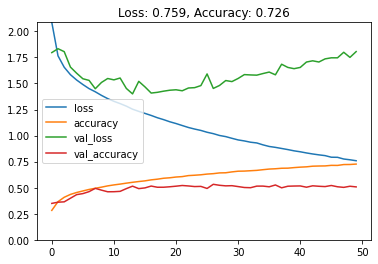

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [ ]:
model = build_basic_model(199)

model.compile(tf.keras.optimizers.Nadam(lr=0.0013),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=True,
                    validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/50
352/352 [==============================] - 2s 5ms/step - loss: 2.0123 - accuracy: 0.2632 - val_loss: 1.9303 - val_accuracy: 0.2974
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 1.7820 - accuracy: 0.3592 - val_loss: 1.7608 - val_accuracy: 0.3646
Epoch 3/50
352/352 [==============================] - 2s 6ms/step - loss: 1.6844 - accuracy: 0.3979 - val_loss: 1.7077 - val_accuracy: 0.3780
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 1.6318 - accuracy: 0.4173 - val_loss: 1.6425 - val_accuracy: 0.4088
Epoch 5/50
352/352 [==============================] - 2s 4ms/step - loss: 1.5810 - accuracy: 0.4357 - val_loss: 1.5898 - val_accuracy: 0.4386
Epoch 6/50
352/352 [==============================] - 2s 5ms/step - loss: 1.5465 - accuracy: 0.4484 - val_loss: 1.5614 - val_accuracy: 0.4412
Epoch 7/50
352/352 [==============================] - 2s 5ms/step - loss: 1.5167 - accuracy: 0.4598 - val_loss: 1.5309 - val_accuracy: 0.4524
Epoch 

Test loss: 1.48
Test accuracy: 0.499


<Figure size 576x432 with 0 Axes>

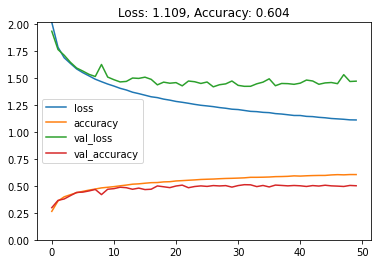

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Drop out model using previosly optmised Hyperparams

Optimiser = **Nadam**

In [ ]:
def build_dropout_model(n_units):
  model = Sequential()
  #adds dropout - turns off some of the hidden layer connections of neurons - 20 % of random connections are droped

  model.add(Dense(units=n_units, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=n_units/4, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

#adds additional dense layers to model
def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=64, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

In [ ]:
opt_dict = {'nadam':tf.keras.optimizers.Nadam,
            'adam':tf.keras.optimizers.Adam,
            'sgd':tf.keras.optimizers.SGD,
            'rmsprop':tf.keras.optimizers.RMSprop,
            'adadelta':tf.keras.optimizers.Adadelta,
            'adagrad':tf.keras.optimizers.Adagrad}

In [ ]:
# build drop-out model with determined n-units from previous optimisation step
model = build_dropout_model(199)

# set all the following values yourself!
optimizer_name  = 'nadam' # any of the following: nadam, adam, sgd, rmsprop, adadelta, adagrad
learning_rate = 0.0012601639723276807 # some number
batch_size = 128 #some integer
training_epochs = 50 # some integer


# selects optimizer and sets learning rate
optimizer = opt_dict[optimizer_name](lr=learning_rate)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=training_epochs, verbose=True, validation_split=.1)

Epoch 1/50
352/352 [==============================] - 3s 5ms/step - loss: 2.0622 - accuracy: 0.2323 - val_loss: 1.8757 - val_accuracy: 0.3120
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 1.8502 - accuracy: 0.3314 - val_loss: 1.7543 - val_accuracy: 0.3712
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 1.7610 - accuracy: 0.3676 - val_loss: 1.7207 - val_accuracy: 0.3876
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 1.7052 - accuracy: 0.3915 - val_loss: 1.6674 - val_accuracy: 0.4082
Epoch 5/50
352/352 [==============================] - 2s 5ms/step - loss: 1.6589 - accuracy: 0.4088 - val_loss: 1.6542 - val_accuracy: 0.4188
Epoch 6/50
352/352 [==============================] - 2s 4ms/step - loss: 1.6256 - accuracy: 0.4202 - val_loss: 1.6827 - val_accuracy: 0.3970
Epoch 7/50
352/352 [==============================] - 2s 4ms/step - loss: 1.5998 - accuracy: 0.4307 - val_loss: 1.6298 - val_accuracy: 0.4210
Epoch 

Test loss: 1.44
Test accuracy: 0.493


<Figure size 576x432 with 0 Axes>

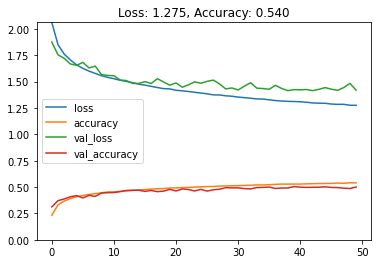

In [ ]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

adding more layers - deeper model

In [ ]:
model = build_deeper_model()

# set all the following values
optimizer_name  = 'nadam' # any of the following: nadam, adam, sgd, rmsprop, adadelta, adagrad
learning_rate = 0.0012601639723276807 # some number
batch_size = 128 #some integer
training_epochs = 10 # some integer


# selects optimizer and sets learning rate
optimizer = opt_dict[optimizer_name](lr=learning_rate)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=training_epochs, verbose=True, validation_split=.1)

Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 1.9905 - accuracy: 0.2724 - val_loss: 1.9288 - val_accuracy: 0.3160
Epoch 2/10
352/352 [==============================] - 2s 4ms/step - loss: 1.8095 - accuracy: 0.3505 - val_loss: 1.8245 - val_accuracy: 0.3440
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 1.7377 - accuracy: 0.3793 - val_loss: 1.7954 - val_accuracy: 0.3522
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 1.7010 - accuracy: 0.3951 - val_loss: 1.7143 - val_accuracy: 0.3882
Epoch 5/10
352/352 [==============================] - 1s 4ms/step - loss: 1.6645 - accuracy: 0.4085 - val_loss: 1.7397 - val_accuracy: 0.3782
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 1.6403 - accuracy: 0.4152 - val_loss: 1.6484 - val_accuracy: 0.4102
Epoch 7/10
352/352 [==============================] - 2s 5ms/step - loss: 1.6157 - accuracy: 0.4228 - val_loss: 1.6289 - val_accuracy: 0.4228
Epoch 

Test loss: 1.59
Test accuracy: 0.432


<Figure size 576x432 with 0 Axes>

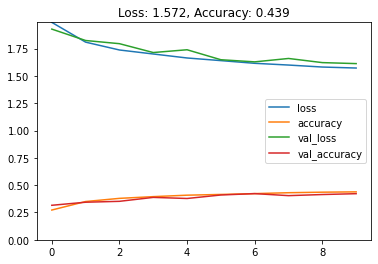

In [ ]:
plot_loss_accuracy(history)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# CNN model


Basic model already defined

Compile model using previously optimised optimiser NADAM

Based on lab 9 (remove)

In [ ]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# converting the data type and scaling between 0 and 1 - normalise the outputs
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

Training data shape:  (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)
Training response shape:,  (50000, 1)
Testing response shape:  (10000, 1)
(32, 32, 3)


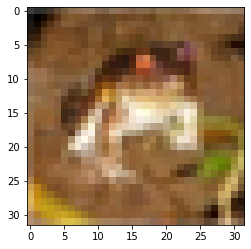

In [ ]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(image_size)

plt.imshow(x_train[0])

In [ ]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1] * image_size[2]


x_train_vector = x_train.reshape(x_train.shape[0], image_vector_size)

x_test_vector = x_test.reshape(x_test.shape[0], image_vector_size)

print(x_train_vector.shape)

(50000, 3072)


In [ ]:
print("First 5 training labels: ", y_train[:5])

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)


In [ ]:
def build_basic_model():
  model = Sequential()
  model.add(Dense(units=1024, activation='relu', input_shape=(image_vector_size,)))
  model.add(Dense(units=256, activation='relu'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_61 (Dense)            (None, 256)               262400    
                                                                 
 dense_62 (Dense)            (None, 10)                2570      
                                                                 
Total params: 3,411,722
Trainable params: 3,411,722
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train for 50 epochs - using previously optmised batch size
history = model.fit(x_train_vector, y_train, batch_size=199, epochs=50, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test_vector, y_test, verbose=False)

Epoch 1/50
227/227 [==============================] - 11s 18ms/step - loss: 2.0361 - accuracy: 0.2807 - val_loss: 2.0397 - val_accuracy: 0.2644
Epoch 2/50
227/227 [==============================] - 3s 14ms/step - loss: 1.7599 - accuracy: 0.3714 - val_loss: 1.7934 - val_accuracy: 0.3610
Epoch 3/50
227/227 [==============================] - 2s 10ms/step - loss: 1.6727 - accuracy: 0.4041 - val_loss: 1.9730 - val_accuracy: 0.3072
Epoch 4/50
227/227 [==============================] - 2s 7ms/step - loss: 1.5935 - accuracy: 0.4348 - val_loss: 1.9691 - val_accuracy: 0.3062
Epoch 5/50
227/227 [==============================] - 2s 7ms/step - loss: 1.5416 - accuracy: 0.4511 - val_loss: 2.0373 - val_accuracy: 0.3310
Epoch 6/50
227/227 [==============================] - 2s 7ms/step - loss: 1.5029 - accuracy: 0.4677 - val_loss: 1.6272 - val_accuracy: 0.4210
Epoch 7/50
227/227 [==============================] - 2s 7ms/step - loss: 1.4535 - accuracy: 0.4832 - val_loss: 1.5444 - val_accuracy: 0.4548
Ep

Test loss: 2.31
Test accuracy: 0.497


<Figure size 576x432 with 0 Axes>

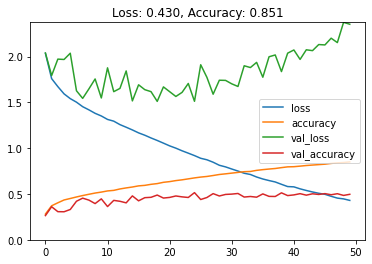

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Build Convolutional neural network

In [ ]:
def build_convnet():
  model = Sequential()

  model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape = image_size))
  model.add(Conv2D(32, (3,3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  # max pooling to get the most important value within a sample of the output from filter or the average value from the convolutional layer



  model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  model.add(Dense(num_classes, activation='softmax'))


  return model
model = build_convnet()
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                 

In [ ]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1, shuffle=True)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

Epoch 1/50
352/352 [==============================] - 12s 15ms/step - loss: 1.7660 - accuracy: 0.3690 - val_loss: 1.5471 - val_accuracy: 0.4394
Epoch 2/50
352/352 [==============================] - 4s 11ms/step - loss: 1.4307 - accuracy: 0.4916 - val_loss: 1.3701 - val_accuracy: 0.5090
Epoch 3/50
352/352 [==============================] - 4s 11ms/step - loss: 1.3109 - accuracy: 0.5374 - val_loss: 1.2603 - val_accuracy: 0.5528
Epoch 4/50
352/352 [==============================] - 4s 11ms/step - loss: 1.2246 - accuracy: 0.5692 - val_loss: 1.1851 - val_accuracy: 0.5856
Epoch 5/50
352/352 [==============================] - 4s 11ms/step - loss: 1.1617 - accuracy: 0.5938 - val_loss: 1.1396 - val_accuracy: 0.5964
Epoch 6/50
352/352 [==============================] - 4s 11ms/step - loss: 1.1063 - accuracy: 0.6140 - val_loss: 1.0955 - val_accuracy: 0.6184
Epoch 7/50
352/352 [==============================] - 4s 11ms/step - loss: 1.0574 - accuracy: 0.6316 - val_loss: 1.0918 - val_accuracy: 0.610

Test loss: 1.89
Test accuracy: 0.686


<Figure size 576x432 with 0 Axes>

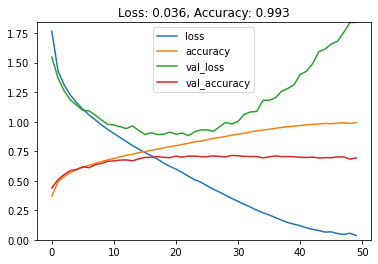

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')